In [249]:
# Question 1
#imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Auto-reload modules when code changes
%load_ext autoreload
%autoreload 2

#importing API's
from dstapi import DstApi

#Plotting setup
plt.rcParams.update({'axes.grid': True, 'grid.color': 'black', 'grid.alpha': 0.25, 'grid.linestyle': '--'})
plt.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
#1.1
# Finding Data
EJ56 = DstApi('EJ56')
EJ56.tablesummary(language='en')

Table EJ56: Price index for sales of property by region, category of real property, unit and time
Last update: 2026-01-08T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,17,000,All Denmark,11,Province Nordjylland,False
1,EJENDOMSKATE,3,0111,One-family houses,2103,"Owner-occupied flats, total",False
2,TAL,3,100,Index,310,Percentage change compared to same quarter the...,False
3,Tid,135,1992K1,1992Q1,2025K3,2025Q3,True


In [251]:
# Checking the parameters available in the dataset
EJ56.variable_levels('OMRÅDE', language='en')


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,02,Province Københavns omegn
4,03,Province Nordsjælland
5,04,Province Bornholm
6,085,Region Sjælland
7,05,Province Østsjælland
8,06,Province Vest- og Sydsjælland
9,083,Region Syddanmark


In [252]:
# Downloading house price data for all provinces and all quarters
params = {
    'table': 'EJ56',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'OMRÅDE', 'values': ['*']},          # All areas
        {'code': 'EJENDOMSKATE', 'values': ['0111']}, # One-family houses (FIXED!)
        {'code': 'TAL', 'values': ['100']},           # Index values
        {'code': 'Tid', 'values': ['*']},             # All time periods
    ]
}

raw = EJ56.get_data(params=params)
display(raw.head(10))
print(f"Number of observations: {len(raw)}")
print(f"Columns: {raw.columns.tolist()}")

,OMRÅDE,EJENDOMSKATE,TAL,TID,INDHOLD
0,All Denmark,One-family houses,Index,2009Q3,68.3
1,Province Byen København,One-family houses,Index,2009Q3,47.9
2,Province Københavns omegn,One-family houses,Index,2009Q3,51.4
3,Province Nordsjælland,One-family houses,Index,2009Q3,58.0
4,Province Bornholm,One-family houses,Index,2009Q3,73.5
5,Province Østsjælland,One-family houses,Index,2009Q3,59.5
6,Province Vest- og Sydsjælland,One-family houses,Index,2009Q3,81.4
7,Province Fyn,One-family houses,Index,2009Q3,78.4
8,Province Sydjylland,One-family houses,Index,2009Q3,83.7
9,Region Nordjylland,One-family houses,Index,2009Q3,80.5


Number of observations: 2295
Columns: ['OMRÅDE', 'EJENDOMSKATE', 'TAL', 'TID', 'INDHOLD']


In [253]:
# Cleaning data and rebasing to 1992Q1 = 100
df = raw.copy()

# Converting time to datetime
df['date'] = pd.PeriodIndex(df['TID'].str.replace('K', 'Q'), freq='Q').to_timestamp()

# Converting price index to float
df['price_index'] = pd.to_numeric(df['INDHOLD'].replace('..', np.nan), errors='coerce')

# Keeping relevant columns
df = df[['OMRÅDE', 'date', 'price_index']]

# Dropping provinces that have ANY missing observations
missing_by_province = df.groupby('OMRÅDE')['price_index'].apply(lambda x: x.isna().sum())
provinces_with_missing = missing_by_province[missing_by_province > 0].index.tolist()
print(f"Provinces dropped due to missing data: {provinces_with_missing}")

df = df[~df['OMRÅDE'].isin(provinces_with_missing)]

# Pivotting to wide format
df_wide = df.pivot(index='date', columns='OMRÅDE', values='price_index')

# Dropping provinces with NaN in base period (1992Q1)
provinces_missing_base = df_wide.iloc[0][df_wide.iloc[0].isna()].index.tolist()
if provinces_missing_base:
    print(f"Provinces dropped due to missing base period: {provinces_missing_base}")
    df_wide = df_wide.drop(columns=provinces_missing_base)

# Rebasing to 1992Q1 = 100
df_rebased = df_wide / df_wide.iloc[0] * 100

print(f"Number of provinces remaining: {df_rebased.shape[1]}")
display(df_rebased.head())

Provinces dropped due to missing data: ['Province Bornholm']
Number of provinces remaining: 16


OMRÅDE,All Denmark,Province Byen København,Province Fyn,Province Københavns omegn,Province Nordjylland,Province Nordsjælland,Province Sydjylland,Province Vest- og Sydsjælland,Province Vestjylland,Province Østjylland,Province Østsjælland,Region Hovedstaden,Region Midtjylland,Region Nordjylland,Region Sjælland,Region Syddanmark
date,,,,,,,,,,,,,,,,
1992-01-01,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1992-04-01,100.000000,101.6,101.086957,98.701299,100.589971,99.473684,99.706745,100.000000,99.50,100.000000,100.000000,100.000000,100.000000,100.589971,100.000000,100.000000
1992-07-01,97.959184,101.6,98.913043,96.103896,97.345133,96.842105,99.120235,97.419355,97.25,100.000000,98.048780,97.546012,98.947368,97.345133,97.735849,99.038462
1992-10-01,95.510204,96.0,96.739130,94.805195,96.460177,93.684211,97.067449,94.516129,95.75,96.296296,94.634146,94.478528,96.140351,96.460177,94.716981,96.794872
1993-01-01,94.285714,96.0,97.101449,92.857143,94.100295,92.631579,95.601173,93.548387,94.50,94.238683,93.170732,93.251534,94.385965,94.100295,93.584906,96.153846


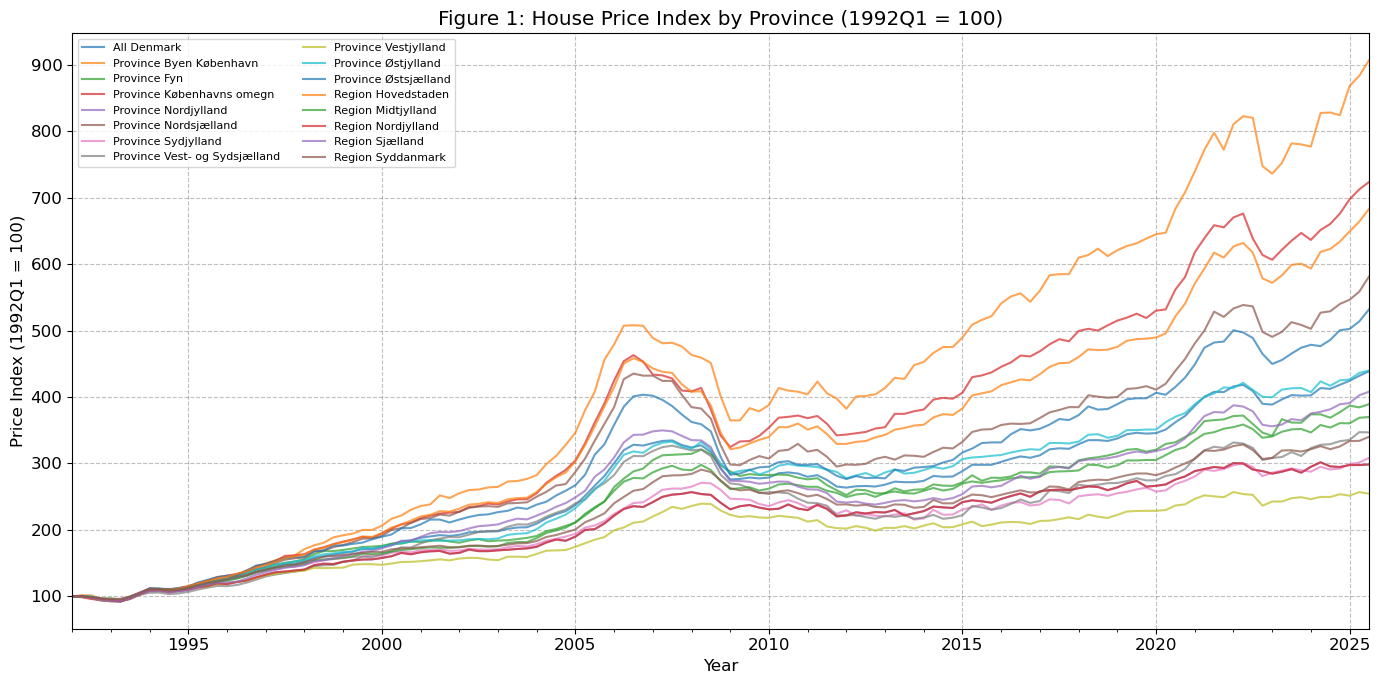

In [254]:
# Plotting house price evolution for all provinces
fig, ax = plt.subplots(figsize=(14, 7))
df_rebased.plot(ax=ax, alpha=0.7)

ax.set_title('Figure 1: House Price Index by Province (1992Q1 = 100)')
ax.set_xlabel('Year')
ax.set_ylabel('Price Index (1992Q1 = 100)')
ax.legend(loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

**Figure 1** shows the evolution of house prices across Danish provinces from 1992 to present, rebased to 1992Q1 = 100. All provinces experienced strong growth until the 2008 financial crisis, followed by a sharp decline. Since then, prices have recovered unevenly, with Copenhagen and surrounding areas showing the strongest growth.

In [255]:
# Ranking provinces by total house price growth
total_growth = ((df_rebased.iloc[-1] / df_rebased.iloc[0]) - 1) * 100
total_growth = total_growth.sort_values(ascending=False)

print("Ranking of provinces by total house price growth (%):\n")
display(total_growth.to_frame('Total Growth (%)').round(1))

Ranking of provinces by total house price growth (%):




,Total Growth (%)
OMRÅDE,
Province Byen København,806.4
Province Københavns omegn,623.4
Region Hovedstaden,582.8
Province Nordsjælland,481.1
Province Østsjælland,431.7
Province Østjylland,339.9
All Denmark,338.8
Region Sjælland,307.9
Province Fyn,289.1


In [256]:
# 1.2 Question 2: Downloading CPI data from PRIS113
PRIS113 = DstApi('PRIS113')
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2026-01-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,552,1980M01,1980M01,2025M12,2025M12,True


In [257]:
# Downloading and cleaning CPI data from PRIS113
params_cpi = {
    'table': 'PRIS113', 'format': 'BULK', 'lang': 'en',
    'variables': [{'code': 'TYPE', 'values': ['INDEKS']}, {'code': 'Tid', 'values': ['*']}]
}
cpi_raw = PRIS113.get_data(params=params_cpi)

# Converting to quarterly CPI
cpi = cpi_raw.copy()
cpi['date'] = pd.to_datetime(cpi['TID'], format='%YM%m')
cpi['cpi'] = pd.to_numeric(cpi['INDHOLD'], errors='coerce')
cpi = cpi.set_index('date')[['cpi']].resample('QS').mean()

display(cpi.head())

,cpi
date,
1980-01-01,33.366667
1980-04-01,34.366667
1980-07-01,35.333333
1980-10-01,36.033333
1981-01-01,36.966667


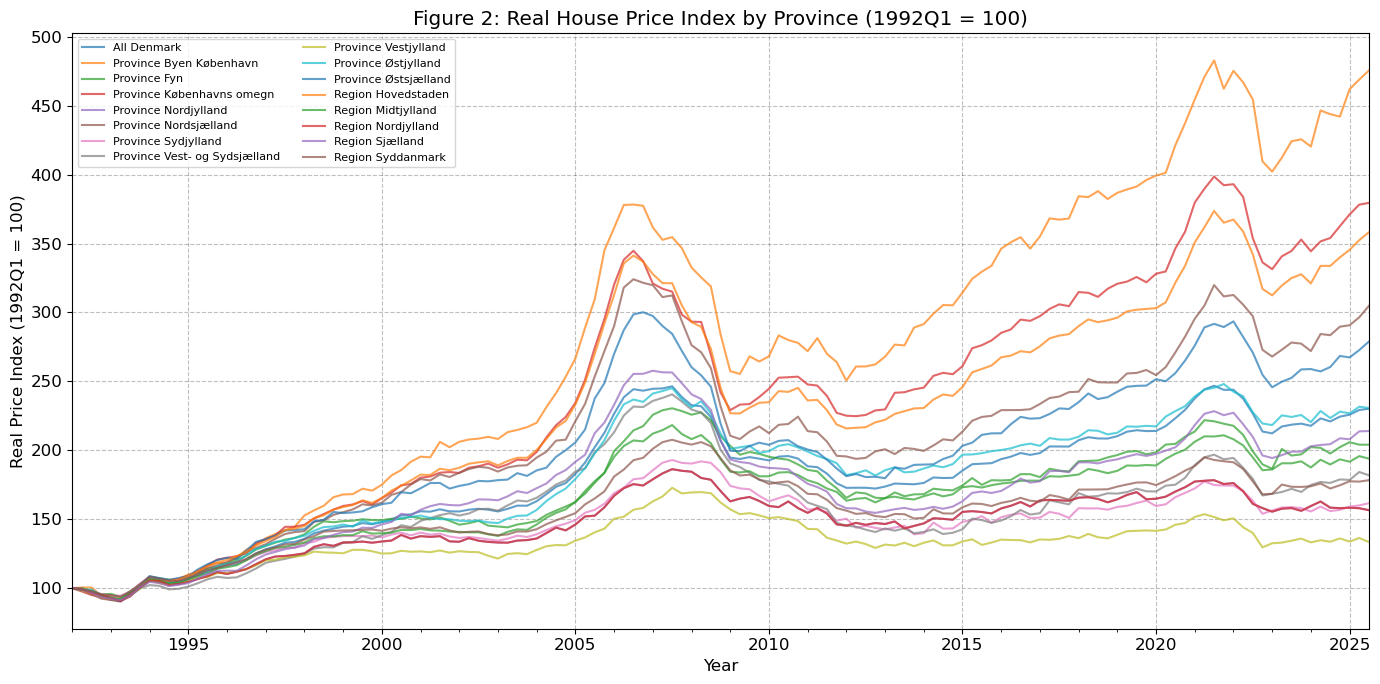

In [258]:
# Calculating real house prices and plot
# Merging CPI with house prices on date
df_nominal = df_wide.reset_index().melt(id_vars='date', var_name='province', value_name='nominal')
cpi_reset = cpi.reset_index()
df_merged = df_nominal.merge(cpi_reset, on='date', how='left')

# Calculating real price index
df_merged['real'] = df_merged['nominal'] / df_merged['cpi'] * 100

# Pivotting back to wide format
df_real_wide = df_merged.pivot(index='date', columns='province', values='real')

# Rebasing to 1992Q1 = 100
df_real_rebased = df_real_wide / df_real_wide.iloc[0] * 100

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
df_real_rebased.plot(ax=ax, alpha=0.7)
ax.set_title('Figure 2: Real House Price Index by Province (1992Q1 = 100)')
ax.set_xlabel('Year')
ax.set_ylabel('Real Price Index (1992Q1 = 100)')
ax.legend(loc='upper left', fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

**Figure 2** displays real (inflation-adjusted) house prices by province, rebased to 1992Q1 = 100. Compared to nominal prices, real growth is more modest. The 2008 crisis caused a sharper real decline, and several provinces have yet to fully recover in real terms.

In [259]:
# 1.3 Question 3: Importing house prices per m² from Excel

# Row 2 contains the quarters (1992Q1, etc.) starting from column 3
quarters = df_raw.iloc[2, 3:].values

# Data starts from row 3, municipality names are in column 2
df_muni = df_raw.iloc[3:, 2:].copy()
df_muni.columns = ['municipality'] + list(quarters)

# Resetting index
df_muni = df_muni.reset_index(drop=True)

# Displaying structure
print(f"Shape: {df_muni.shape}")
print(f"Columns (first 10): {df_muni.columns[:10].tolist()}")
display(df_muni.head(10))

Shape: (98, 135)
Columns (first 10): ['municipality', '1992Q1', '1992Q2', '1992Q3', '1992Q4', '1993Q1', '1993Q2', '1993Q3', '1993Q4', '1994Q1']


,municipality,1992Q1,1992Q2,1992Q3,1992Q4,1993Q1,1993Q2,1993Q3,1993Q4,1994Q1,...,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1,2024Q2,2024Q3,2024Q4,2025Q1,2025Q2
0,København,5355,5451,5374,5171,5068,5186,5609,5519,5503,...,43538,46023,47651,48146,47769,51843,52011,54143,56588,56744
1,Frederiksberg,5183,5626,6980,6686,5537,7047,6651,6174,6558,...,67716,67981,69455,72835,69100,75199,79964,79804,82363,..
2,Dragør,6251,6472,6364,6246,6158,6438,6573,6261,5969,...,33809,33105,35803,33492,34092,35732,41012,36296,36214,40602
3,Tårnby,5747,6003,6075,5856,5275,5860,5976,5916,6196,...,30923,31249,33712,34524,32718,35569,34602,35882,36194,37924
4,Albertslund,5240,5408,5417,5341,5130,4773,5746,5492,5616,...,23417,23360,23703,24200,23486,24548,24941,26787,25764,26737
5,Ballerup,5696,6015,5771,5203,5925,5647,5813,6163,6132,...,28512,27256,29300,29008,29088,30221,30813,29735,33278,35127
6,Brøndby,5663,6501,5947,5846,4823,6205,6752,6263,6934,...,27103,26368,26712,25921,28633,29854,28456,29424,30704,29708
7,Gentofte,6783,7378,7288,6860,6692,6840,7348,7667,7652,...,52584,58970,57708,56496,56506,56348,56866,62780,63178,61358
8,Gladsaxe,6157,6163,6374,5533,5850,6147,6300,6370,6470,...,36647,36071,37903,38726,38884,40007,40931,41054,43592,44819
9,Glostrup,5401,5106,4992,4602,4490,5017,5524,4687,5234,...,25866,28410,30474,28096,28450,30041,30586,31045,30127,34440


In [260]:
# Cleaning data - dropping municipalities with any missing observations
df_muni = df_muni.set_index('municipality')

# Dropping rows containing '..' 
df_muni_clean = df_muni[~(df_muni == '..').any(axis=1)]

# Converting to numeric
df_muni_clean = df_muni_clean.apply(pd.to_numeric, errors='coerce')

print(f"Municipalities dropped: {len(df_muni) - len(df_muni_clean)}")
print(f"Municipalities remaining: {len(df_muni_clean)}")

# Calculating initial price (first column) and total growth
initial_price = df_muni_clean.iloc[:, 0]
final_price = df_muni_clean.iloc[:, -1]
total_growth = ((final_price / initial_price) - 1) * 100

# Creating summary dataframe
summary = pd.DataFrame({
    'initial_price': initial_price,
    'total_growth': total_growth
})
display(summary.head(10))

Municipalities dropped: 6
Municipalities remaining: 92


,initial_price,total_growth
municipality,,
København,5355,959.645191
Dragør,6251,549.528076
Tårnby,5747,559.892118
Albertslund,5240,410.248092
Ballerup,5696,516.695927
Brøndby,5663,424.598269
Gentofte,6783,804.584992
Gladsaxe,6157,627.935683
Glostrup,5401,537.659693


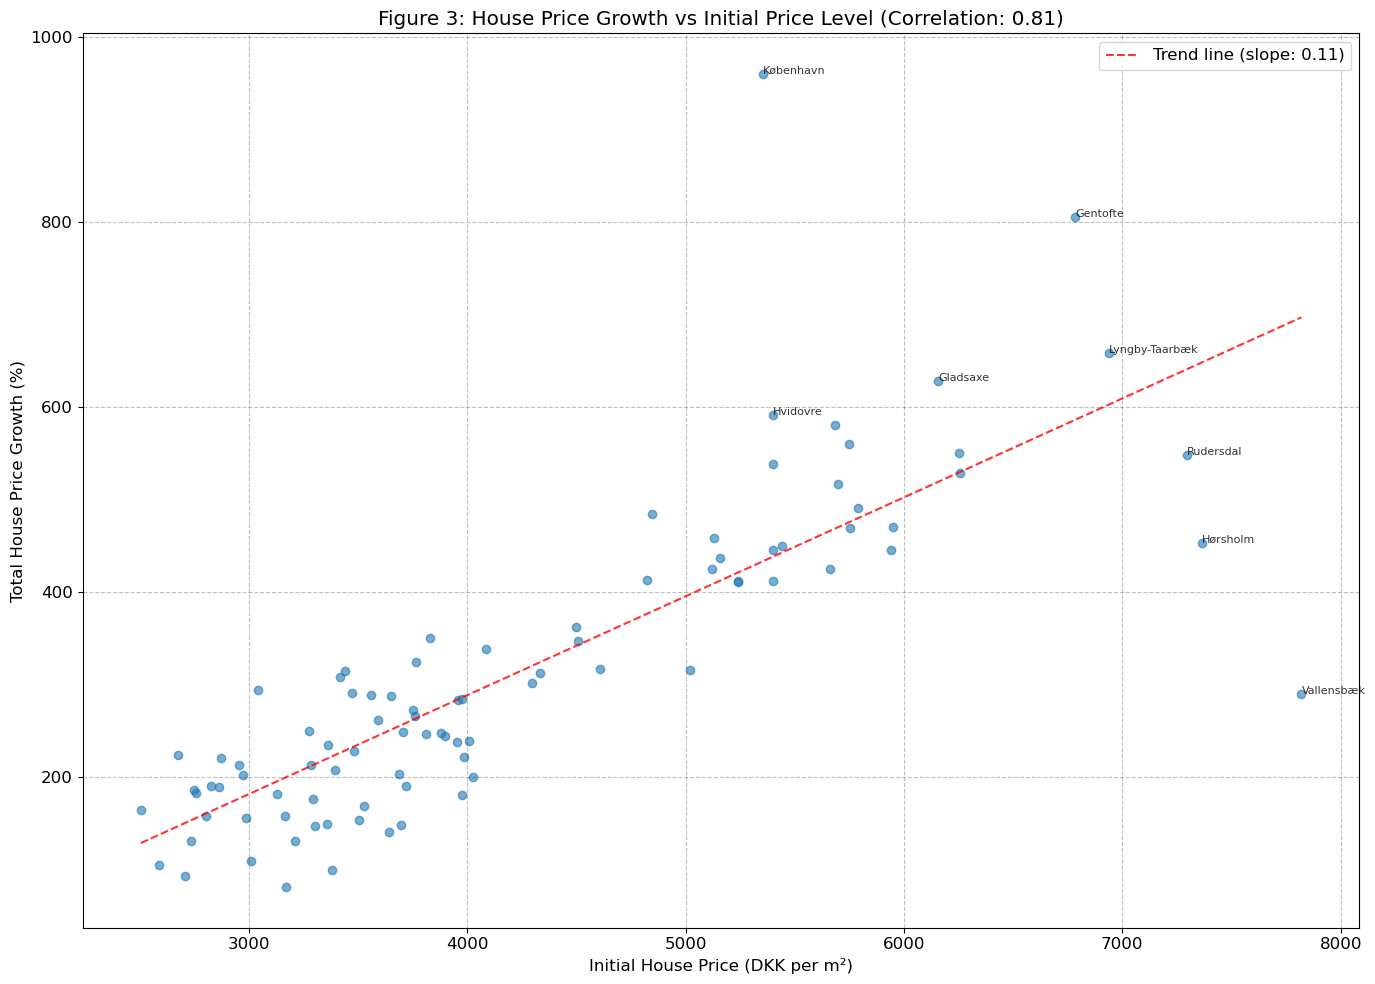


Correlation between initial price and total growth: 0.814
The correlation is positive.

Top 5 by total growth: ['København', 'Gentofte', 'Lyngby-Taarbæk', 'Gladsaxe', 'Hvidovre']
Top 5 by initial price: ['Vallensbæk', 'Hørsholm', 'Rudersdal', 'Lyngby-Taarbæk', 'Gentofte']


In [261]:
# Plotting total growth vs initial price level
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(summary['initial_price'], summary['total_growth'], alpha=0.6)

# Finding top 5 by growth and top 5 by initial price
top5_growth = summary.nlargest(5, 'total_growth')
top5_initial = summary.nlargest(5, 'initial_price')

# Combining and get unique municipalities to label
to_label = pd.concat([top5_growth, top5_initial]).drop_duplicates()

# Adding labels only for top municipalities
for muni in to_label.index:
    ax.annotate(muni, 
                (summary.loc[muni, 'initial_price'], summary.loc[muni, 'total_growth']),
                fontsize=8, alpha=0.8)

# Adding trend line (linear regression)
z = np.polyfit(summary['initial_price'], summary['total_growth'], 1)
p = np.poly1d(z)
x_line = np.linspace(summary['initial_price'].min(), summary['initial_price'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'Trend line (slope: {z[0]:.2f})')

# Calculating correlation
corr = summary['initial_price'].corr(summary['total_growth'])
ax.set_title(f'Figure 3: House Price Growth vs Initial Price Level (Correlation: {corr:.2f})')
ax.set_xlabel('Initial House Price (DKK per m²)')
ax.set_ylabel('Total House Price Growth (%)')
ax.legend()
plt.tight_layout()
plt.show()

# Answering the question
print(f"\nCorrelation between initial price and total growth: {corr:.3f}")
print(f"The correlation is {'positive' if corr > 0 else 'negative'}.")

# Showing which municipalities are labeled
print(f"\nTop 5 by total growth: {top5_growth.index.tolist()}")
print(f"Top 5 by initial price: {top5_initial.index.tolist()}")

**Figure 3** shows a positive correlation between initial house price levels and total growth. Municipalities with higher initial prices (e.g., Copenhagen area) have experienced stronger price growth, while lower-priced municipalities have seen more modest increases. This suggests a divergence in the Danish housing market, where expensive areas have become relatively more expensive over time. The labeled dots are are the municipalities with the highest total house price growth and/or the largest initial house price levels. 

In [262]:
# 1.4 Question 4: Rolling average and peak analysis
df_muni_rolling = df_muni_clean.T.rolling(window=4, min_periods=4).mean().T
df_muni_rolling.columns = pd.PeriodIndex(df_muni_rolling.columns, freq='Q').to_timestamp()

# Finding peak before 2008 and computing change
pre_crisis = df_muni_rolling.loc[:, :pd.Timestamp('2008-07-01')]
peak_summary = pd.DataFrame({
    'peak_value': pre_crisis.max(axis=1),
    'latest_value': df_muni_rolling.iloc[:, -1],
    'change_%': ((df_muni_rolling.iloc[:, -1] / pre_crisis.max(axis=1)) - 1) * 100
})
display(peak_summary.head(10))

,peak_value,latest_value,change_%
municipality,,,
København,28362.75,54871.50,93.463257
Dragør,28376.00,38531.00,35.787285
Tårnby,25115.00,36150.50,43.939877
Albertslund,20976.50,26057.25,24.221152
Ballerup,23475.75,32238.25,37.325751
Brøndby,23781.75,29573.00,24.351656
Gentofte,36840.50,61045.50,65.702148
Gladsaxe,27959.50,42599.00,52.359663
Glostrup,23529.75,31549.50,34.083448


Below peak: 21, Above peak: 71


,peak_value,latest_value,change_%
municipality,,,
Lolland,6345.8,4953.5,-21.9
Langeland,7334.8,6019.0,-17.9
Vordingborg,10926.5,9011.5,-17.5
Norddjurs,8504.8,7130.5,-16.2
Haderslev,8736.5,7605.0,-13.0
Struer,8348.8,7282.0,-12.8
Stevns,14803.2,13149.0,-11.2
Odsherred,11473.0,10305.5,-10.2
Guldborgsund,8589.2,7774.2,-9.5


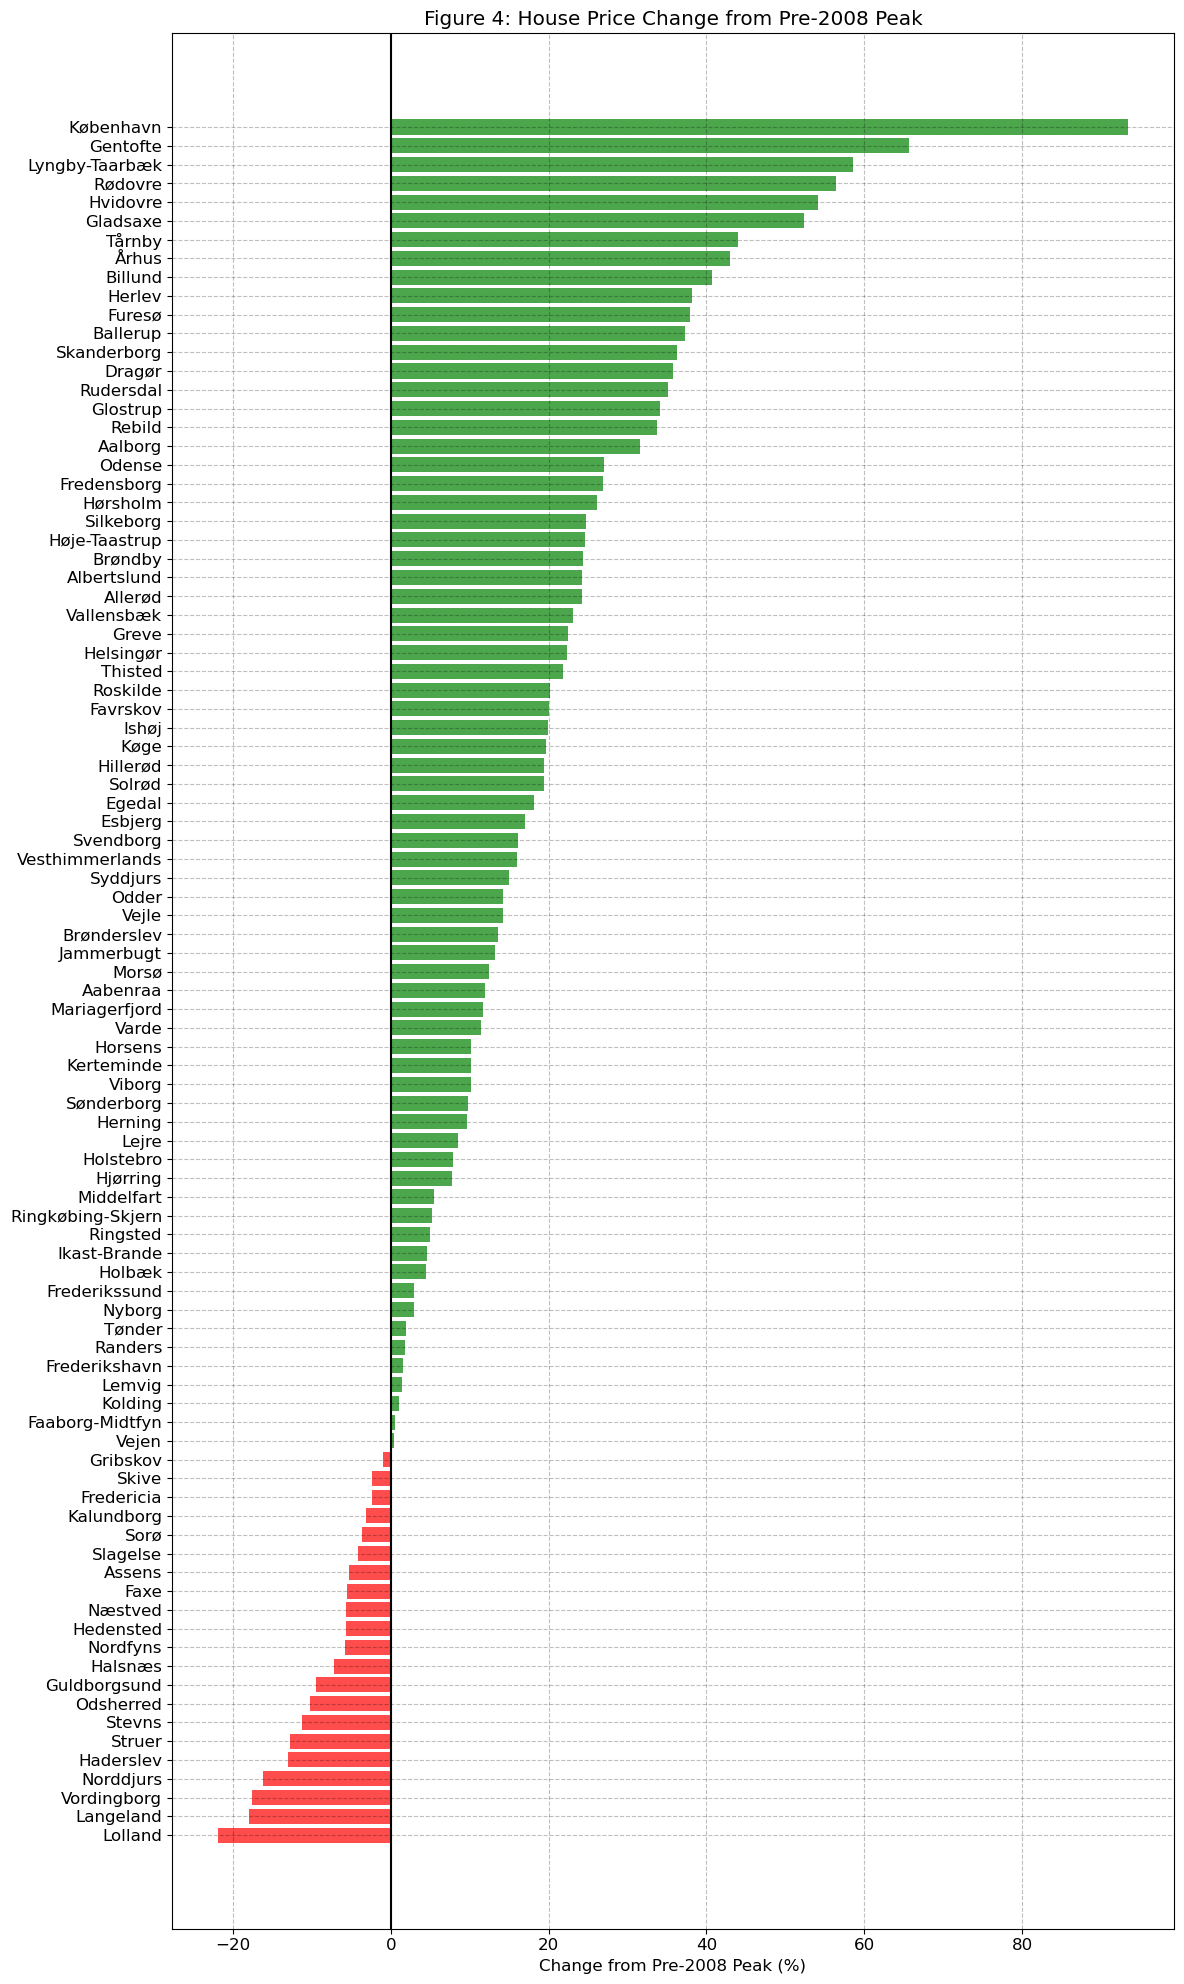

In [263]:
# Finding municipalities still below their pre-crisis peak
below_peak = peak_summary[peak_summary['change_%'] < 0].sort_values('change_%')
print(f"Below peak: {len(below_peak)}, Above peak: {len(peak_summary) - len(below_peak)}")
if len(below_peak) > 0:
    display(below_peak.round(1))

# Bar chart
fig, ax = plt.subplots(figsize=(12, 20))
sorted_data = peak_summary.sort_values('change_%')
colors = ['red' if x < 0 else 'green' for x in sorted_data['change_%']]
ax.barh(sorted_data.index, sorted_data['change_%'], color=colors, alpha=0.7)
ax.axvline(0, color='black')
ax.set_xlabel('Change from Pre-2008 Peak (%)')
ax.set_title('Figure 4: House Price Change from Pre-2008 Peak')
plt.tight_layout()
plt.show()

**Figure 4** shows that most Danish municipalities have recovered above their pre-2008 peak house prices. However, several municipalities in peripheral areas (e.g., Lolland, Vordingborg, Langeland) remain significantly below their peak. In contrast, Copenhagen and its surrounding municipalities (Gentofte, Lyngby-Taarbæk, Frederiksberg) have experienced the strongest growth, exceeding their pre-crisis peaks by 60-90%. This illustrates a widening geographic divide in the Danish housing market.